# reset output folder


In [ ]:
# Cell 1: Import necessary libraries
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances


**Process videos and extract keyframes**

In [ ]:
# Cell 5: Compress the output folder and download (for Google Colab)

#import shutil
#shutil.make_archive(output_folder, 'zip', output_folder)

# If using Google Colab, download the ZIP file
#from google.colab import files
#files.download(f'{output_folder}.zip')#


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 # Video Summarization using Keyframe Extraction and Video Skimming

In [ ]:
!pip install transformers torch requests matplotlib


In [ ]:
!wget https://github.com/michael-franke/npNLG/raw/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
!unzip A3DS.zip -d A3DS


--2024-09-13 19:51:53--  https://github.com/michael-franke/npNLG/raw/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip [following]
--2024-09-13 19:51:53--  https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31636302 (30M) [application/zip]
Saving to: ‘A3DS.zip’

A3DS.zip            100%[===================>]  30.17M   191MB/s    in 0.2s    

2024-09-13 19:51:55 (191 MB/s) - ‘A3DS.zip’ saved [3

In [ ]:
cd content/

/content


In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset
import requests
import torch
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Initialize Hugging Face's GPT2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# Example text to tokenize
text = "This is an example sentence for tokenization."

# Tokenize the text using GPT2TokenizerFast
tokenized_text = tokenizer(text, return_tensors="pt")

# Print the tokenized output
print(tokenized_text)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

{'input_ids': tensor([[ 1212,   318,   281,  1672,  6827,   329, 11241,  1634,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel


# Cell 2: Define helper functions for video keyframe extraction

# Step 1: Video frames pre-sampling
def pre_sample_frames(video_path, sample_rate=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % sample_rate == 0:  # Sample every 'sample_rate' frames
            frames.append(frame)
        frame_count += 1
    cap.release()
    return frames

# Step 2: Color feature extraction
def extract_color_features(frames):
    features = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (64, 64))  # Resize for faster computation
        feature = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2HSV).flatten()  # Convert to HSV and flatten
        features.append(feature)
    return np.array(features)

# Step 3: Elimination of meaningless frames
def eliminate_meaningless_frames(frames, features, threshold=50):
    meaningful_frames = []
    meaningful_features = []
    for frame, feature in zip(frames, features):
        if np.std(feature) > threshold:  # Eliminate low variance frames (low information)
            meaningful_frames.append(frame)
            meaningful_features.append(feature)
    return meaningful_frames, np.array(meaningful_features)

# Step 4: Frames clustering
def cluster_frames(features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(features)
    return clusters

# Step 5: Keyframe extraction using keycluster selection (VSUMM2)
def extract_keyframes_with_keycluster_selection(frames, clusters, features):
    keyframes = []
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
    average_cluster_size = np.mean(cluster_counts)
    keyclusters = unique_clusters[cluster_counts > (0.5 * average_cluster_size)]

    for cluster_id in keyclusters:
        cluster_features = features[clusters == cluster_id]
        cluster_frames = np.array(frames)[clusters == cluster_id]
        centroid = np.mean(cluster_features, axis=0)
        distances = pairwise_distances([centroid], cluster_features)
        keyframe_idx = np.argmin(distances)
        keyframes.append(cluster_frames[keyframe_idx])
    return keyframes

# Step 6: Elimination of similar keyframes
def eliminate_similar_keyframes(keyframes, threshold=0.9):
    final_keyframes = [keyframes[0]]
    for i in range(1, len(keyframes)):
        similarity = np.mean(cv2.absdiff(final_keyframes[-1], keyframes[i])) / 255.0
        if similarity < threshold:
            final_keyframes.append(keyframes[i])
    return final_keyframes


# Cell 3: Define the main function to summarize video and extract keyframes

def summarize_video_vsumm2(video_path, sample_rate=30, n_clusters=10, keyframe_threshold=0.9):
    frames = pre_sample_frames(video_path, sample_rate)
    features = extract_color_features(frames)
    meaningful_frames, meaningful_features = eliminate_meaningless_frames(frames, features)
    clusters = cluster_frames(meaningful_features, n_clusters)
    keyframes = extract_keyframes_with_keycluster_selection(meaningful_frames, clusters, meaningful_features)
    final_keyframes = eliminate_similar_keyframes(keyframes, threshold=keyframe_threshold)
    return final_keyframes

# Function to process all videos in the input folder and save keyframes
def process_videos_in_folder(input_folder, output_folder, sample_rate=30, n_clusters=10, keyframe_threshold=0.9):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for video_file in os.listdir(input_folder):
        video_path = os.path.join(input_folder, video_file)
        if os.path.isfile(video_path):
            video_output_folder = os.path.join(output_folder, os.path.splitext(video_file)[0])
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            keyframes = summarize_video_vsumm2(video_path, sample_rate, n_clusters, keyframe_threshold)
            print(f"Processed {video_file} - Number of keyframes: {len(keyframes)}")

            # Save keyframes in the video-specific folder
            for idx, keyframe in enumerate(keyframes):
                keyframe_path = os.path.join(video_output_folder, f'Keyframe_{idx}.jpg')
                cv2.imwrite(keyframe_path, keyframe)

# Cell 4: Process videos and extract keyframes

# Define the input and output folder paths
input_folder = 'input_videos_for_key_frame'
output_folder = 'output_key_frames'

# Create input and output folders if they don't exist
if not os.path.exists(input_folder):
    os.makedirs(input_folder)
    print(f"Input folder '{input_folder}' created. Please add videos to this folder.")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Output folder '{output_folder}' created.")

# Process the videos and extract keyframes (if videos are available in the input folder)
if os.listdir(input_folder):
    process_videos_in_folder(input_folder, output_folder, sample_rate=15, n_clusters=15, keyframe_threshold=0.85)
else:
    print(f"No videos found in the '{input_folder}' folder. Please add videos to process.")



Processed xukun.mp4 - Number of keyframes: 11
Processed 7 Recipes You Can Make In 5 Minutes.mp4 - Number of keyframes: 8
Extracted keyframes from videos in 'input_videos_for_key_frame' and saved to 'output_key_frames'.

Generating captions for extracted keyframes...


Processing folder: 7 Recipes You Can Make In 5 Minutes
Generating caption for Keyframe_4.jpg:


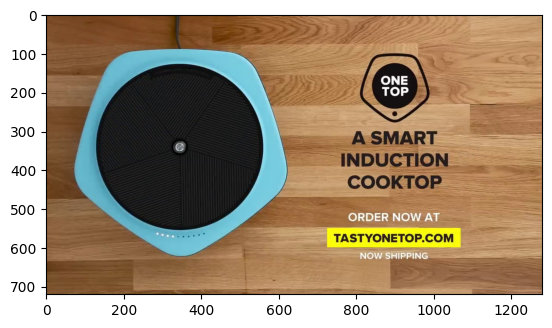

Generated caption: the black and white photo shows an advertisement for a skateboard 


Generating caption for Keyframe_2.jpg:


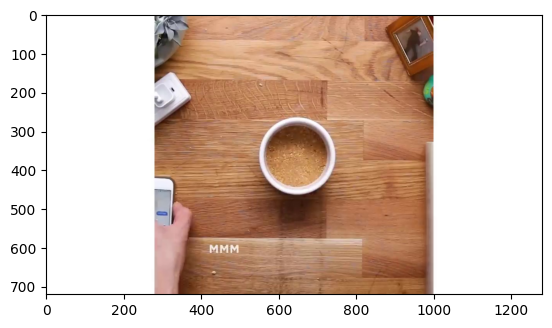

Generated caption: a cup of coffee sitting on the counter 


Generating caption for Keyframe_0.jpg:


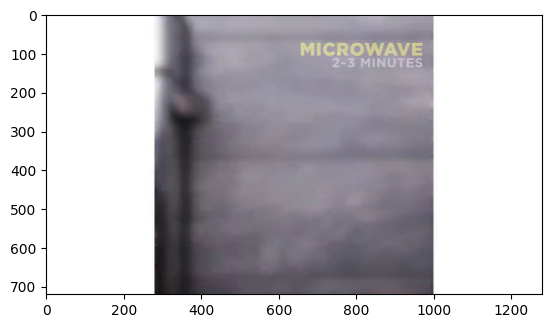

Generated caption: a sign hanging on a post on a wall 


Generating caption for Keyframe_5.jpg:


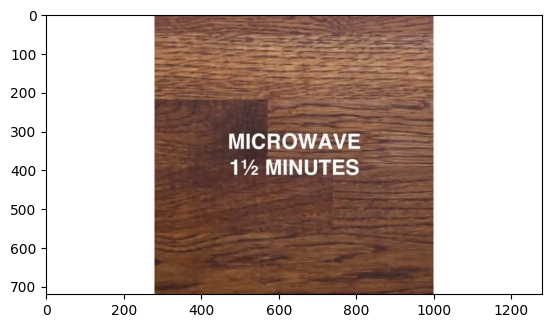

Generated caption: a wooden wooden wall with writing on it 


Generating caption for Keyframe_1.jpg:


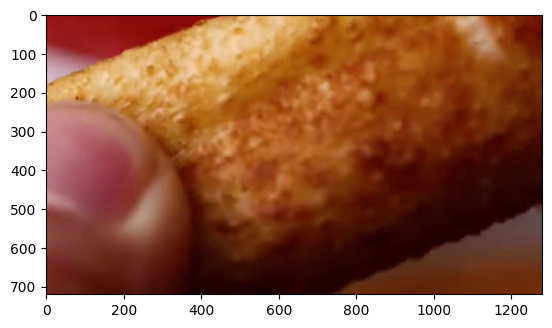

Generated caption: a person holding a piece of bread with a knife 


Generating caption for Keyframe_3.jpg:


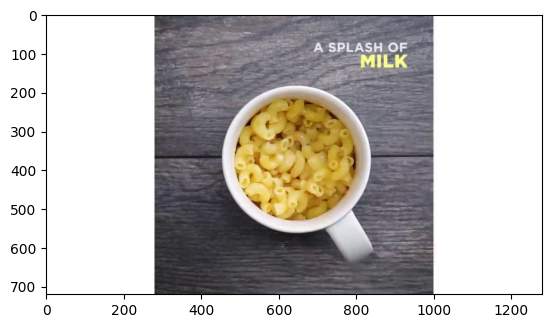

Generated caption: a white spoon with some food in it 


Generating caption for Keyframe_6.jpg:


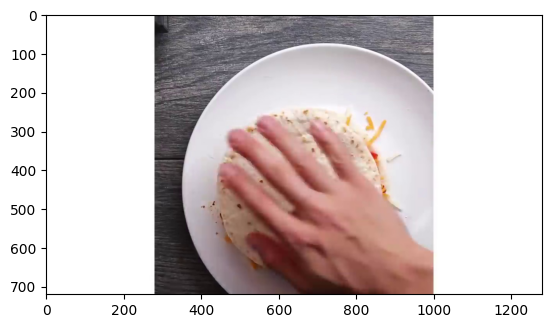

Generated caption: a plate with two slices of bread with a knife 


Generating caption for Keyframe_7.jpg:


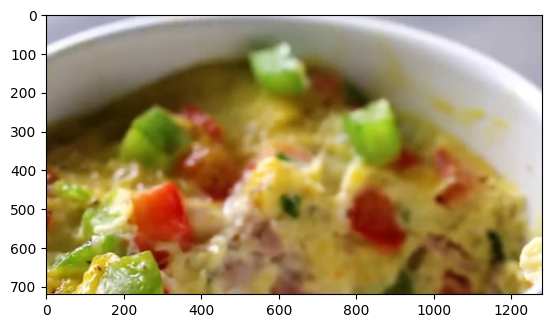

Generated caption: a bowl filled with a mixture of food 



Processing folder: xukun
Generating caption for Keyframe_4.jpg:


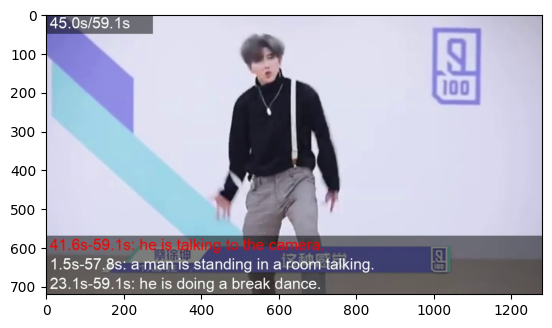

Generated caption: a young male wearing a black shirt and a black and white shirt 


Generating caption for Keyframe_2.jpg:


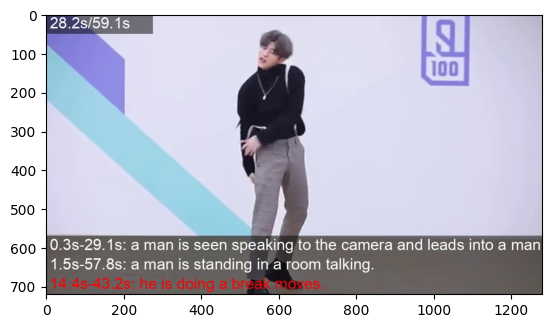

Generated caption: a man standing on a podium with a sign in the background 


Generating caption for Keyframe_0.jpg:


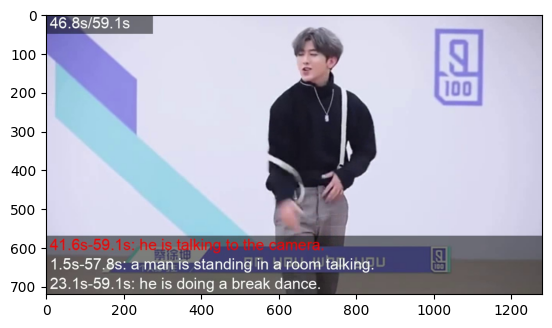

Generated caption: a man wearing a suit standing in front of a wall holding a remote 


Generating caption for Keyframe_8.jpg:


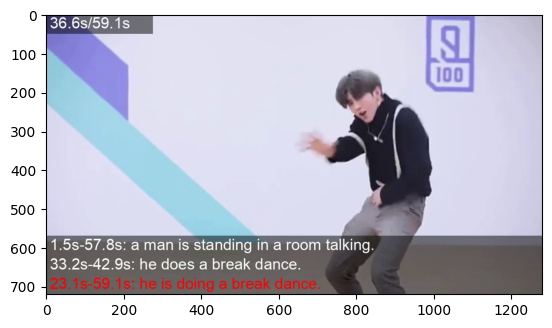

Generated caption: a man in a blue shirt is using a mobile device to talk 


Generating caption for Keyframe_5.jpg:


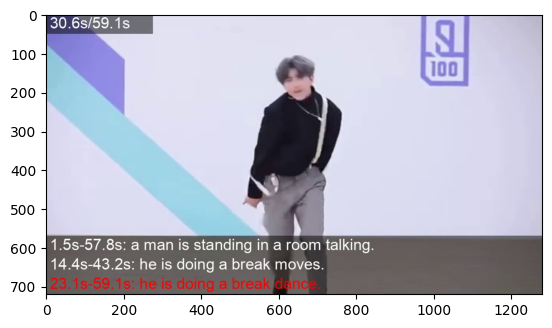

Generated caption: a person standing in a room with a wall 


Generating caption for Keyframe_1.jpg:


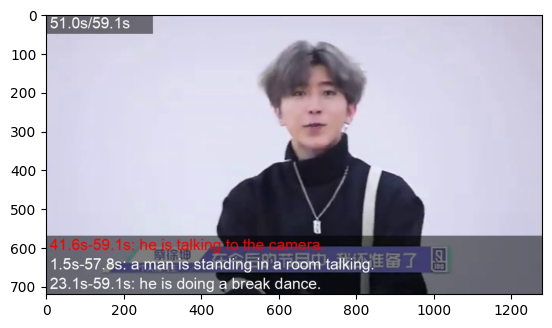

Generated caption: a young boy with a black and white background 


Generating caption for Keyframe_3.jpg:


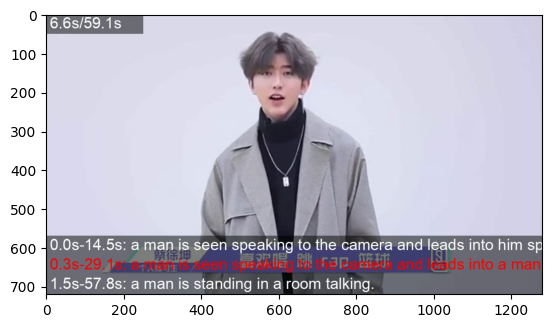

Generated caption: a person in a suit and a tie 


Generating caption for Keyframe_6.jpg:


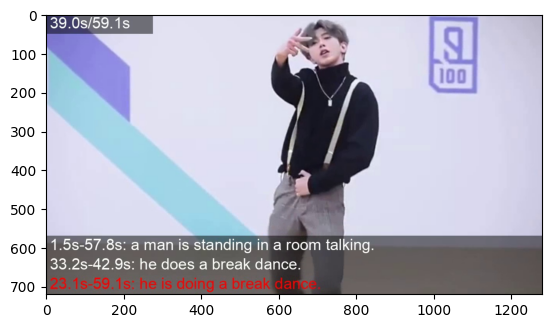

Generated caption: a man is holding a cell phone in his hand 


Generating caption for Keyframe_10.jpg:


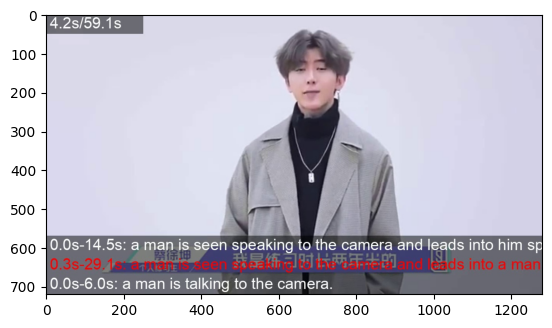

Generated caption: a man in black and white holding a sign 


Generating caption for Keyframe_7.jpg:


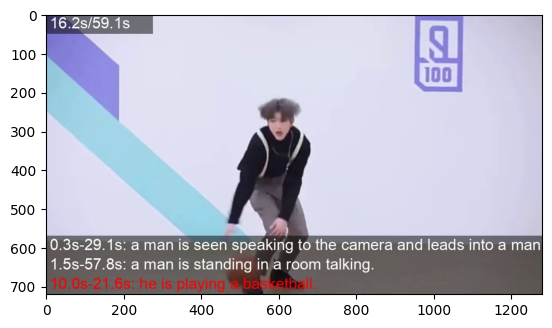

Generated caption: a woman is standing on a stage talking on a cell phone 


Generating caption for Keyframe_9.jpg:


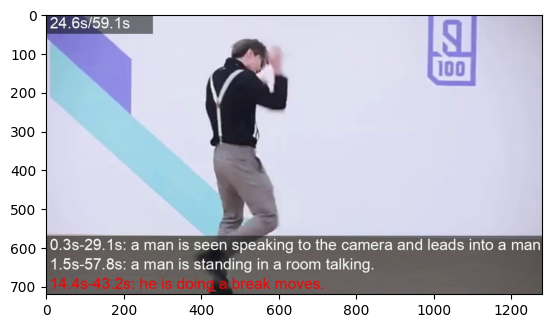

Generated caption: a man is standing in front of an american flag 



Processing folder: .ipynb_checkpoints


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel


# Initialize the tokenizer and model
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Function to display the image and generate a caption
def show_n_generate(image_path, greedy=True, model=model):
    image = Image.open(image_path)
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy:
        generated_ids = model.generate(pixel_values, max_new_tokens=30)
    else:
        generated_ids = model.generate(
            pixel_values,
            do_sample=True,
            max_new_tokens=30,
            top_k=5)

    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"Generated caption: {generated_text}")

# Function to process videos and extract keyframes
def process_videos_in_folder(input_folder, output_folder, sample_rate=15, n_clusters=15, keyframe_threshold=0.85):
    # Simulate the extraction of keyframes (you can insert your keyframe extraction logic here)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # For demonstration, assume keyframes are extracted
    print(f"Extracted keyframes from videos in '{input_folder}' and saved to '{output_folder}'.")

# Define the input and output folder paths
input_folder = 'input_videos_for_key_frame'
output_folder = 'output_key_frames'

# Create input and output folders if they don't exist
if not os.path.exists(input_folder):
    os.makedirs(input_folder)
    print(f"Input folder '{input_folder}' created. Please add videos to this folder.")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Output folder '{output_folder}' created.")

# Process the videos and extract keyframes (if videos are available in the input folder)
if os.listdir(input_folder):
    process_videos_in_folder(input_folder, output_folder, sample_rate=15, n_clusters=15, keyframe_threshold=0.85)
else:
    print(f"No videos found in the '{input_folder}' folder. Please add videos to process.")

# Step 2: Generate captions for the extracted keyframes
print("\nGenerating captions for extracted keyframes...\n")
if os.path.exists(output_folder):
    # Iterate over each subfolder in the output folder
    for subfolder in os.listdir(output_folder):
        subfolder_path = os.path.join(output_folder, subfolder)
        if os.path.isdir(subfolder_path):  # Ensure it's a directory
            print(f"\nProcessing folder: {subfolder}")

            # Iterate over all images in the subfolder
            for image_file in os.listdir(subfolder_path):
                if image_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the file is an image
                    image_path = os.path.join(subfolder_path, image_file)
                    print(f"Generating caption for {image_file}:")
                    show_n_generate(image_path, greedy=False)
                    print("\n")
else:
    print(f"The folder '{output_folder}' does not exist.")
